In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scorecardpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


In [2]:
df = pd.read_csv('Loan_Default_imputed.csv')

In [3]:
df.Status = df.Status.astype(int)

Weight of Evidence (WOE) And Information Value (IV) will be used to select features usefull for classification

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
bins = sc.woebin(df, y='Status')

[INFO] creating woe binning ...
Binning on 143942 rows and 31 columns in 00:00:27


In [6]:
df_woe = sc.woebin_ply(df, bins)

[INFO] converting into woe values ...
Woe transformating on 143942 rows and 30 columns in 00:00:13


In [7]:
iv_values = {col: bin_df['total_iv'].iloc[0] for col, bin_df in bins.items()}
iv_df = pd.DataFrame(list(iv_values.items()), columns=['Variable', 'IV'])


In [8]:
iv_df.sort_values(by='IV', ascending=False)

,Variable,IV
22,credit_type,4.657177
19,rate_of_interest,0.619766
7,Interest_rate_spread,0.231496
13,income,0.154297
20,dtir1,0.141857
6,co-applicant_credit_type,0.110648
1,submission_of_application,0.084715
24,Neg_ammortization,0.083731
8,LTV,0.062206
11,loan_amount,0.040660


In [9]:
features=iv_df[iv_df['IV']>=0.03]['Variable'].to_list()

After calculating IV, we conclude that the features 'business_or_commercial', 'rate_of_interest', 'Gender', 'loan_type', 'income', 'Neg_ammortization', 'dtir1', 'credit_type', 'property_value','Interest_rate_spread', 'LTV', 'loan_amount', 'submission_of_application', 'co-applicant_credit_type', 'Upfront_charges' have sufficient predictive power (IV>=0.03) and would be used to train models.

In [10]:
features.append('Status')

In [11]:
df_learn = df[features]
df_learn.head()

,submission_of_application,Gender,co-applicant_credit_type,Interest_rate_spread,LTV,loan_amount,income,business_or_commercial,rate_of_interest,dtir1,credit_type,Neg_ammortization,loan_type,property_value,Status
0,to_inst,Sex Not Available,CIB,0.522692,98.728814,116500.0,1740.0,nob/c,4.199231,45.000000,EXP,not_neg,type1,118000.000000,1
1,to_inst,Male,EXP,1.006962,87.282005,206500.0,4980.0,b/c,3.940000,43.615385,EQUI,not_neg,type2,228769.230769,1
2,to_inst,Male,CIB,0.200000,80.019685,406500.0,9480.0,nob/c,4.560000,46.000000,EXP,neg_amm,type1,508000.000000,0
3,not_inst,Male,CIB,0.681000,69.376900,456500.0,11880.0,nob/c,4.250000,42.000000,EXP,not_neg,type1,658000.000000,0
4,not_inst,Joint,EXP,0.304200,91.886544,696500.0,10440.0,nob/c,4.000000,39.000000,CRIF,not_neg,type1,758000.000000,0


In [12]:
numerical_columns = df_learn.select_dtypes(include=[np.number]).columns.to_list()
categorical_columns = df_learn.select_dtypes(include=['object']).columns.tolist()

oh = OneHotEncoder(sparse_output=False, handle_unknown='ignore').set_output(transform='pandas')
sc = RobustScaler()
encoded = oh.fit_transform(df_learn[categorical_columns])
scaled = pd.DataFrame(sc.fit_transform(df_learn[numerical_columns]), columns = numerical_columns)
df_enc_scal = pd.concat([encoded, scaled], axis=1)

In [13]:
df_enc_scal.head()

,submission_of_application_not_inst,submission_of_application_to_inst,Gender_Female,Gender_Joint,Gender_Male,Gender_Sex Not Available,co-applicant_credit_type_CIB,co-applicant_credit_type_EXP,business_or_commercial_b/c,business_or_commercial_nob/c,...,loan_type_type2,loan_type_type3,Interest_rate_spread,LTV,loan_amount,income,rate_of_interest,dtir1,property_value,Status
0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.163920,0.984135,-0.750000,-0.857143,0.318501,0.545455,-0.882353,1.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.906550,0.506653,-0.375000,-0.155844,-0.076112,0.419580,-0.556561,1.0
2,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,-0.330931,0.203719,0.458333,0.818182,0.867681,0.636364,0.264706,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.406686,-0.240224,0.666667,1.337662,0.395785,0.272727,0.705882,0.0
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,-0.171139,0.698722,1.666667,1.025974,0.015222,0.000000,1.000000,0.0


In [14]:
X, y = df_enc_scal.drop('Status', axis=1), df_enc_scal.Status

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Logistic Regression

The GridSearchCV would be used for parameter tuning and cross validation.

In the first Logistic Regression model, our focus will be on achieving the highest possible overall score.

In [16]:
logistic_model = LogisticRegression(max_iter=500, solver='lbfgs', n_jobs=-1)
param_grid_log = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l2',  None],
    'class_weight':[None, 'balanced']
}
grid_search_logistic = GridSearchCV(logistic_model, param_grid_log, cv=5, n_jobs=-1)
grid_search_logistic.fit(X_train, y_train)

print("Best Parameters:", grid_search_logistic.best_params_)
print("Best Score:", grid_search_logistic.best_score_)

Best Parameters: {'C': 0.01, 'class_weight': None, 'penalty': 'l2'}
Best Score: 0.8575026161665129


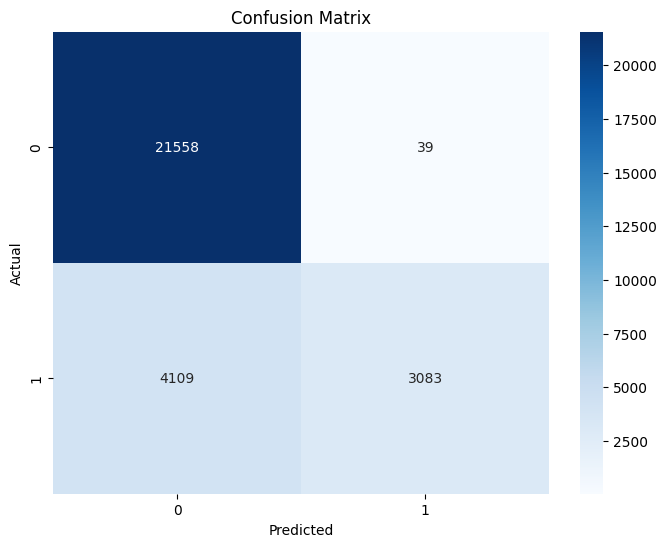

In [17]:
y_pred_log = grid_search_logistic.best_estimator_.predict(X_test)
cm_log = confusion_matrix(y_test,y_pred_log)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_log, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In the second Logistic Regression model, our primary objective will be to reduce False Negatives, which occur when loans are approved for individuals who ultimately default on repayment. By focusing on minimizing False Negatives, we aim to enhance the model's ability to accurately identify borrowers who may pose a higher risk of default. This strategic approach helps in mitigating financial losses for lenders.

In [18]:
logistic_model_rec = LogisticRegression(max_iter=500, solver='lbfgs', n_jobs=-1)
param_grid_log_rec = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l2',  None],
    'class_weight':[None, 'balanced']
}
grid_search_logistic_rec = GridSearchCV(logistic_model_rec, param_grid_log_rec, cv=5, n_jobs=-1, scoring='recall')
grid_search_logistic_rec.fit(X_train, y_train)

print("Best Parameters:", grid_search_logistic_rec.best_params_)
print("Best Score:", grid_search_logistic_rec.best_score_)

Best Parameters: {'C': 0.0001, 'class_weight': 'balanced', 'penalty': 'l2'}
Best Score: 0.6151158806959559


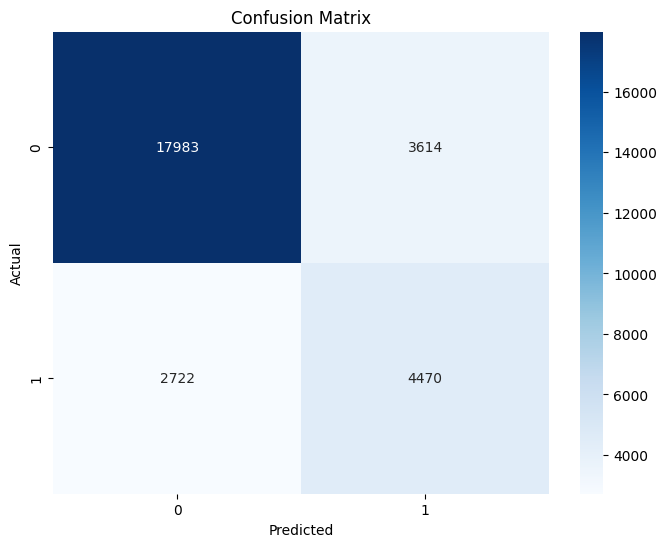

In [19]:
y_rec_pred = grid_search_logistic_rec.best_estimator_.predict(X_test)
cm_log_rec = confusion_matrix(y_test,y_rec_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_log_rec, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

The overall accuracy of the second model is lower compared to the first model. However, we achieved a significant reduction in False Negatives and an increase in True Positives.

# Decision Tree

In [ ]:
param_grid_tree = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 8, 10, 15, 25, 35, 40],
    'min_samples_split': [2, 3, 5, 8],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': [None, 'sqrt', 'log2'],
    'splitter': ['best', 'random']
}
dec_tree = DecisionTreeClassifier(random_state=14)
grid_search_dec_tree = GridSearchCV(estimator=dec_tree, param_grid=param_grid_tree, cv=5, verbose=True, n_jobs=-1)
grid_search_dec_tree.fit(X_train, y_train)

print("Best Parameters:", grid_search_dec_tree.best_params_)
print("Best Score:", grid_search_dec_tree.best_score_)

Fitting 5 folds for each of 1344 candidates, totalling 6720 fits
Best Parameters: {'criterion': 'entropy', 'max_depth': 25, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'splitter': 'best'}
Best Score: 0.9954929534553033


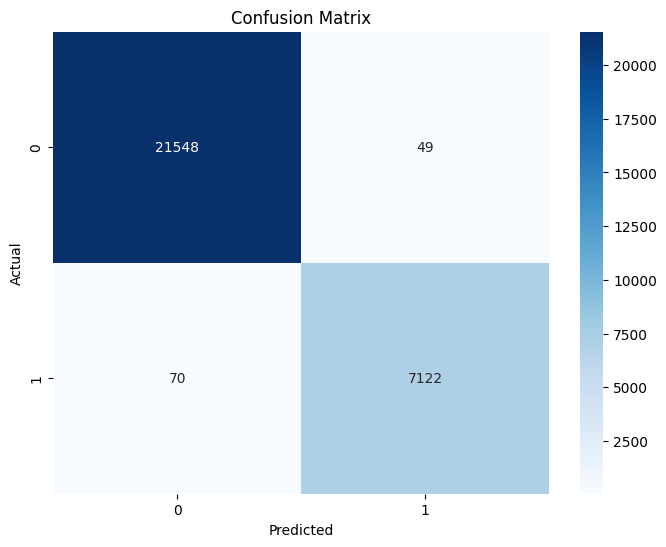

In [ ]:
y_tree_pred = grid_search_dec_tree.best_estimator_.predict(X_test)
cm_tree = confusion_matrix(y_test,y_tree_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_tree, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
dec_tree_rec = DecisionTreeClassifier(random_state=14)
grid_search_dec_tree_rec = GridSearchCV(estimator=dec_tree, param_grid=param_grid_tree, cv=5, verbose=True, n_jobs=-1, scoring='recall')
grid_search_dec_tree_rec.fit(X_train, y_train)

print("Best Parameters:", grid_search_dec_tree_rec.best_params_)
print("Best Score:", grid_search_dec_tree_rec.best_score_)

Fitting 5 folds for each of 1344 candidates, totalling 6720 fits
Best Parameters: {'criterion': 'entropy', 'max_depth': 25, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
Best Score: 0.9885970913921824


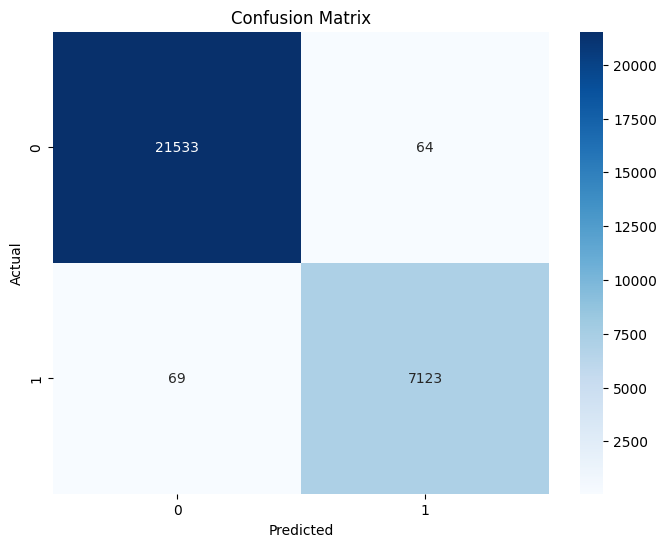

In [ ]:
y_tree_rec_pred = grid_search_dec_tree_rec.best_estimator_.predict(X_test)
cm_tree_rec = confusion_matrix(y_test,y_tree_rec_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_tree_rec, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

There is no significant difference between models.

# XGBoost

In [27]:
param_grid_xgb = {
              'max_depth': [15, 20, 30],
              'learning_rate': [0.01, 0.05, 0.1],
              'min_child_weight': [1, 3, 5, 7]}

xgb_cls = xgb.XGBClassifier(objective='binary:logistic', tree_method="gpu_hist")
grid_search_xgb = GridSearchCV(estimator=xgb_cls, param_grid=param_grid_xgb ,cv=5, n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)

print("Best Parameters:", grid_search_xgb.best_params_)
print("Best Score:", grid_search_xgb.best_score_)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 15, 'min_child_weight': 3}
Best Score: 0.9790713006217733


In [28]:
print("Best Parameters:", grid_search_xgb.best_params_)
print("Best Score:", grid_search_xgb.best_score_)


Best Parameters: {'learning_rate': 0.1, 'max_depth': 15, 'min_child_weight': 3}
Best Score: 0.9790713006217733


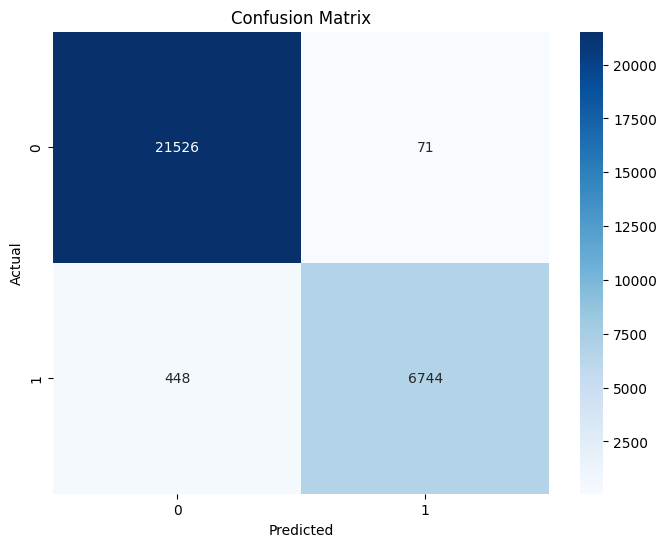

In [29]:
y_xgb_pred = grid_search_xgb.best_estimator_.predict(X_test)
cm_xgb = confusion_matrix(y_test,y_xgb_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [34]:
param_grid_xgb_rec = {
              'max_depth': [10, 15, 20],
              'learning_rate': [0.01, 0.05, 0.1],
              'min_child_weight': [1, 3, 5, 7, 9],
              'scale_pos_weight': [3, 5, 7] }


xgb_cls_rec = xgb.XGBClassifier(objective='binary:logistic', n_jobs=-1, tree_method="gpu_hist")
grid_search_xgb_rec = GridSearchCV(estimator=xgb_cls_rec, param_grid=param_grid_xgb_rec, cv=5, n_jobs=-1, scoring='recall')
grid_search_xgb_rec.fit(X_train, y_train)

print("Best Parameters:", grid_search_xgb_rec.best_params_)
print("Best Score:", grid_search_xgb_rec.best_score_)

Best Parameters: {'learning_rate': 0.01, 'max_depth': 15, 'min_child_weight': 7, 'scale_pos_weight': 7}
Best Score: 0.9606240426237889


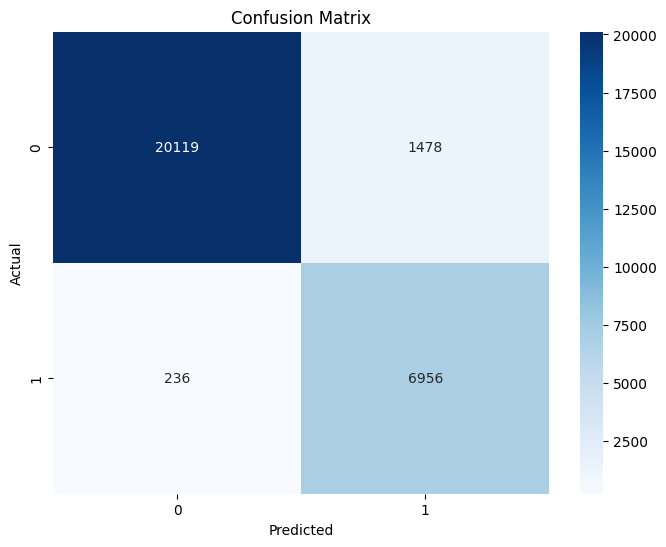

In [35]:
y_xgb_rec_pred = grid_search_xgb_rec.best_estimator_.predict(X_test)
cm_xgb_rec = confusion_matrix(y_test,y_xgb_rec_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb_rec, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

We focused on reducing false negatives in our XGBoost model to enhance the detection of positive cases, which led to an increase in true positives. This strategic decision resulted in a trade-off with overall accuracy.



# Random Forest

In [26]:
param_grid_rfc = {
    'n_estimators': [30],
    'max_features': [None, 'sqrt'],
    'max_depth': [20, 30, 40, None],                      
    'min_samples_leaf': [20, 30, 40],
    'criterion': ['gini', 'entropy']
}

rfc = RandomForestClassifier(random_state=42, n_jobs=-1)
grid_search_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid_rfc ,cv=5, n_jobs=-1, verbose=2)
grid_search_rfc.fit(X_train, y_train)

print("Best Parameters:", grid_search_rfc.best_params_)
print("Best Score:", grid_search_rfc.best_score_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters: {'criterion': 'entropy', 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 20, 'n_estimators': 30}
Best Score: 0.9936345558374727


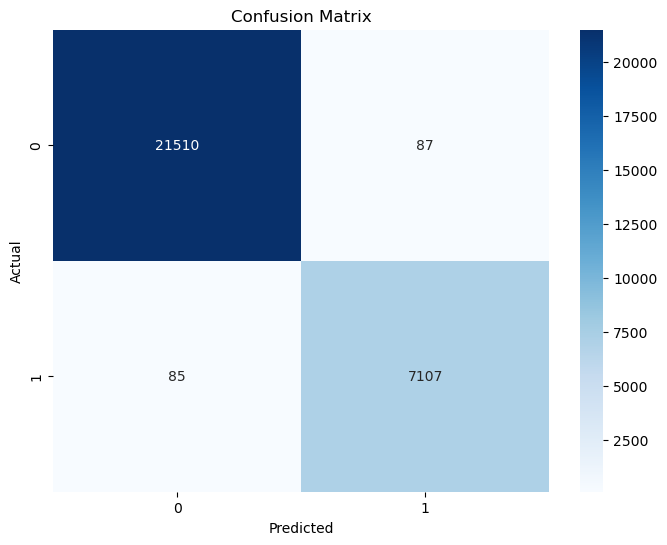

In [27]:
y_rfc_pred = grid_search_rfc.best_estimator_.predict(X_test)
cm_rfc = confusion_matrix(y_test,y_rfc_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_rfc, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [32]:
grid_search_rfc_rec = GridSearchCV(estimator=rfc, param_grid=param_grid_rfc ,cv=5, n_jobs=-1, verbose=2, scoring = 'recall')
grid_search_rfc_rec.fit(X_train, y_train)

print("Best Parameters:", grid_search_rfc_rec.best_params_)
print("Best Score:", grid_search_rfc_rec.best_score_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters: {'criterion': 'entropy', 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 20, 'n_estimators': 30}
Best Score: 0.98613838610831


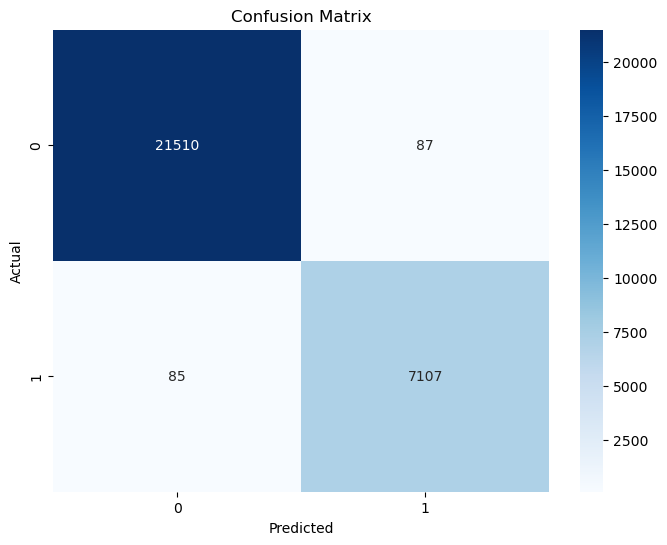

In [34]:
y_rfc_rec_pred = grid_search_rfc_rec.best_estimator_.predict(X_test)
cm_rfc_rec = confusion_matrix(y_test,y_rfc_rec_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_rfc_rec, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

After evaluation, the Decision Tree model proved most effective in predicting loan defaulters, followed by Random Forest, which outperformed XGBoost and Logistic Regression.

